# CNNs for regression tasks

Convolutional Neural Networks (CNNs) are widely used for image classification tasks, but they can also be effectively applied to regression tasks. In regression tasks, the goal is to predict a continuous output variable based on input data. 

On of the key elements in regression tasks using CNNs is the choice of the activation function in the convolutional (and fully connected) layers. While ReLU (Rectified Linear Unit) is a popular choice for classification tasks, it may not always be the best option for regression tasks.

In [2]:
# Import necessary modules

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the data

We can now import the data to display several examples.

In [ ]:
data_df = pd.read_csv('./data/labels.csv')
images, angles = [], []
for idx, row in data_df.iterrows():
    img = plt.imread(os.path.join('./data/images', row['image_name']))
    images.append(img)
    angles.append(row['angle'])
    
images = np.array(images)
angles = np.array(angles)

In [16]:
print(f'Number of samples: {len(images)}')
print(f'Image shape: {images[0].shape}')

Number of samples: 10
Image shape: (64, 64, 4)


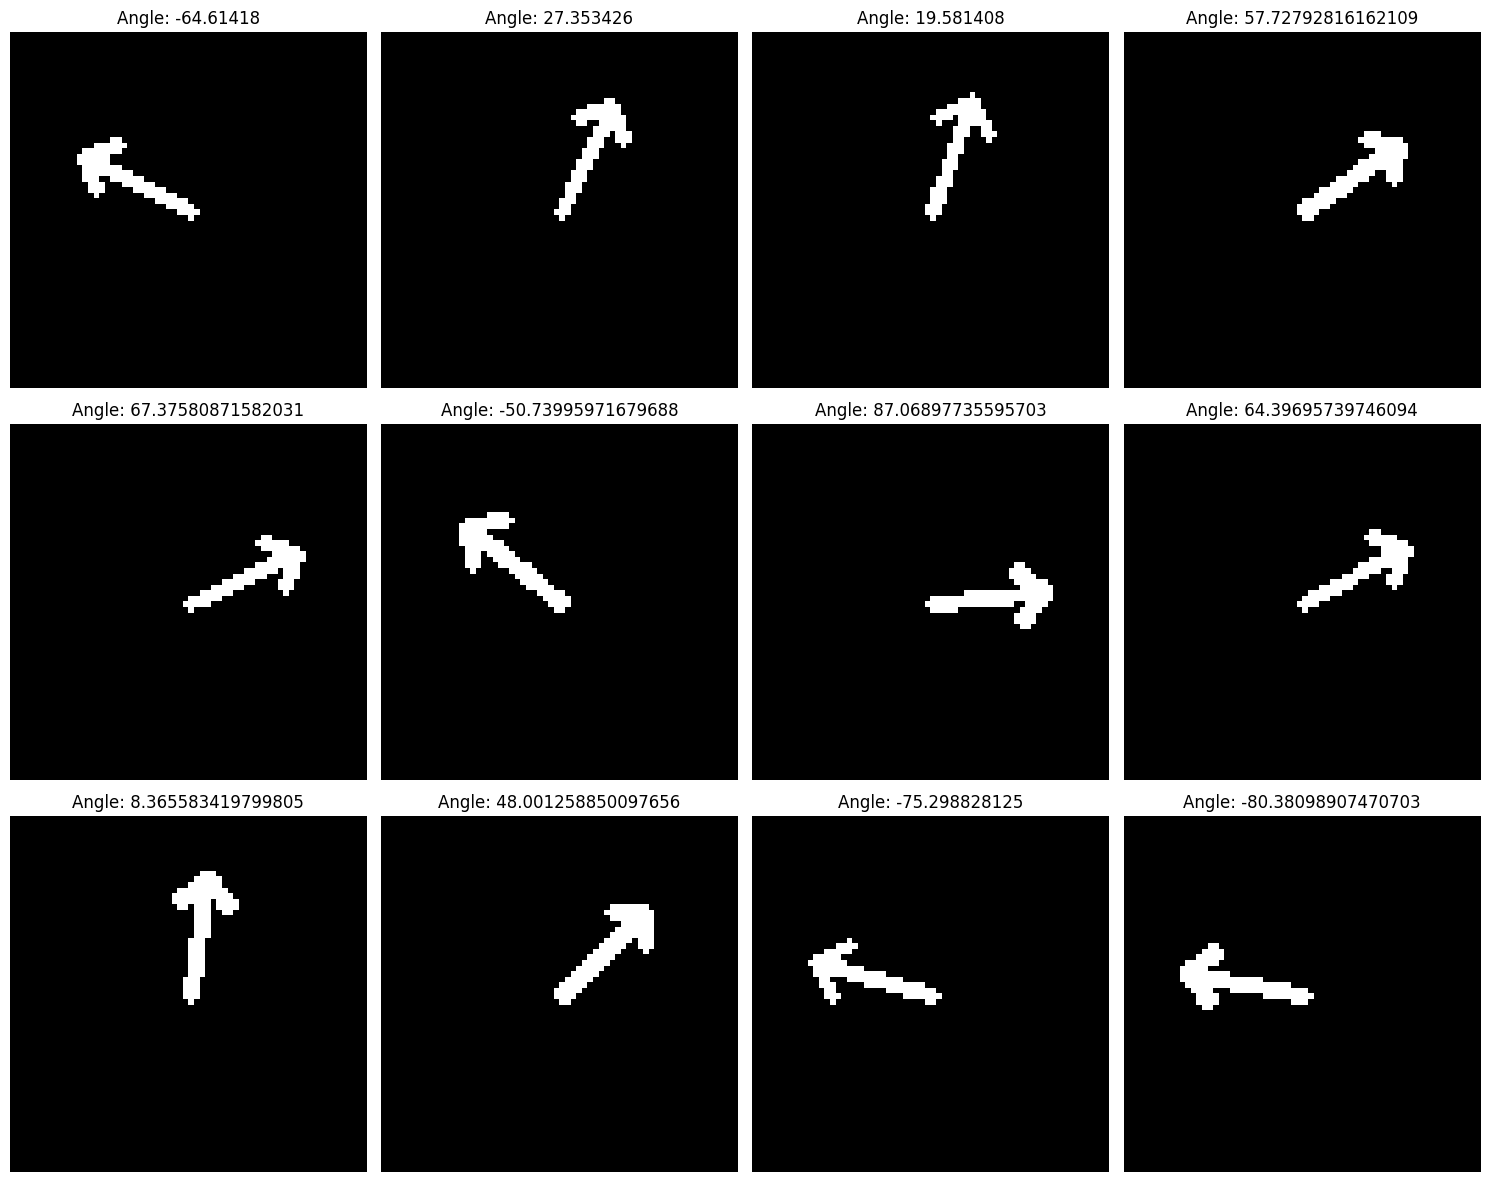

In [7]:
# Display several examples (12)
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f'Angle: {angles[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

<ins>Note :</ins> Each angle is between -90 and 90 degrees. The angles are continuous values, measured in degrees and represent the orientation of the object in the image with respect to the y-axis (vertical axis). An angle of 0 degrees indicates that the object is perfectly vertical, while positive angles indicate a clockwise rotation and negative angles indicate a counterclockwise rotation.